<font color='green' size='7'>**Аналитика больших данных. RF Regressor, Feature engineering**</font>  


**Отбор признаков с помощью алгоритма Случайного леса**





**Описание плана работы**

1. Загрузка набора данных из библиотеки tsfresh Human Activity Recognition dataset.
2.	Разделение данных на тестовую и тренировочную. Тестовая выборка - 20%.
3.	Обучение классификатора Случайного леса (DecisionTreeClassifier) на тренировочной выборке.
4. Оценка классификатора по критериям Accuracy, Precision, Recall и F1 (classification_report). Выводы по критериям.
5. Выбор признаков из классификатора. Построение графика важности признаков. Выводы.
6. Применение к датасету функции из библиотеки tsfresh: extract_features, extract_relevant_features, impute, select_features.
7. Разделение отфильтрованных данных на тестовую и тренировочную выборки. Тестовая выборка - 20%.
8. Обучение классификатора Случайного леса (DecisionTreeClassifier) на тренировочной выборке с отфильтрованными данными.
9. Оценка классификатора по критериям Accuracy, Precision, Recall и F1 (classification_report). Выводы по критериям.



# <font color='#11a642' size='6'> Импорт и установка библиотек

In [ ]:
!pip install --upgrade scipy
!pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
  Using cached scipy-1.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
# установка дополнительной библиотеки
!pip install tsfresh
!pip install stumpy

  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 7.5 MB/s eta 0:00:00
Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd # работа с таблицами
import numpy as np # математические вычисления

%matplotlib inline
import matplotlib.pyplot as plt # визуализация данных
from matplotlib import style  # стиль визуализации данных

plt.rcParams["figure.figsize"] = (10,5) # размер графиков
plt.style.use('fivethirtyeight') # стиль графиков, альтернативный style.use('ggplot')

from sklearn.tree import DecisionTreeClassifier # классификатор дерева решений
from sklearn.model_selection import train_test_split  # разделение на тестовую и тренировочную выборки
from sklearn.metrics import classification_report # метрики классификатора
from sklearn.preprocessing import StandardScaler # нормализация данных по стандартному отклонению
from sklearn.ensemble import RandomForestClassifier # Классификатор случайного леса

from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures # Загрузить набор данных о сбоях робота  https://github.com/MaxBenChrist/robot-failure-dataset/

# extract_features - извлечь все признаки, extract_relevant_features - извлечь релевантные признаки
# select_features рассчитывает важность текущего признака для предсказания класса
from tsfresh import extract_features, extract_relevant_features, select_features

from tsfresh.utilities.dataframe_functions import impute # заполнить пропуски, удалите все значения NaN, scikit-learn аналог
from tsfresh.utilities.dataframe_functions import roll_time_series # скользящее окно по данным

# генерация новых признаков
# TimeBasedFCParameters рассчитает линейный тренд, R^2, intercept, slope, стандартную ошибку и p-value добавить расчеты к признакам
from tsfresh.feature_extraction.settings import TimeBasedFCParameters

# MinimalFCParameters рассчитает сумму, медиану, среднее, длину, стандартное отклонение, дисперсию, максимальное и минимальное значения каждого ряда
# EfficientFCParameters рассчитает коэффициенты skewness и kurtosis, повтор минимума и максимума, квантили, оконные статистики, автокорреляции и др
# ComprehensiveFCParameters самый большой и полный вариант, добавляются неэффективные в вычислительном плане признаки, но модель порой обучается лучше
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters, ComprehensiveFCParameters

import plotly.express as px

# <font color='#11a642' size='6'> Загрузка данных


In [ ]:
# Загрузка данных из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes

Загрузить набор данных из библиотеки tsfresh Human Activity Recognition dataset

In [ ]:
download_har_dataset()
data = load_har_dataset()
y = load_har_classes()

In [ ]:
data.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127],
      dtype='int64', length=128)

# <font color='#11a642' size='6'> Разведочный анализ данных (EDA)

## <font color='#11a642' size='5'> Оценка размера датасета





1.   Сколько весит датасет
2.   Сколько строк и столбцов


In [ ]:
# Сколько kБ датасет
size_byte = data.memory_usage(index=True).sum()
size_kb = size_byte / 1024

size_data = size_kb

print(f"The dataset df is {size_data:.2f} kB")

The dataset df is 7352.12 kB


In [ ]:
# Сколько строк и столбцов
data.shape

(7352, 128)

## <font color='#11a642' size='5'> Анализ пропусков и выбросов


In [ ]:
# Основные статистики датасета
data.describe().T

,count,mean,std,min,25%,50%,75%,max
0,7352.0,-0.003374,0.198317,-0.857863,-0.038449,-0.000718,0.008661,1.133144
1,7352.0,-0.002858,0.197407,-0.897771,-0.037463,-0.000747,0.008745,1.091050
2,7352.0,-0.001708,0.197976,-0.975056,-0.036089,-0.000624,0.008930,1.097443
3,7352.0,-0.000536,0.196811,-0.984342,-0.033924,-0.000658,0.008600,1.046354
4,7352.0,0.000333,0.195771,-0.886248,-0.033026,-0.000719,0.008426,1.107588
...,...,...,...,...,...,...,...,...
123,7352.0,0.000752,0.194513,-0.746925,-0.023871,-0.000575,0.006518,1.128485
124,7352.0,0.001230,0.195691,-0.897870,-0.024126,-0.000617,0.006584,1.082167
125,7352.0,0.000948,0.196523,-0.865697,-0.022968,-0.000460,0.007144,1.180790
126,7352.0,0.000916,0.197047,-0.750321,-0.024064,-0.000694,0.006665,1.155468


In [ ]:
# Проверка пропусков
data.isna().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
123,0
124,0
125,0
126,0


In [ ]:
# Поиск выбросов
results = {'Столбец': [], 'Выбросы': []}
# Расчет IQR
for column in data:
  Q1 = data[column].quantile(0.25)
  Q3 = data[column].quantile(0.75)
  IQR = Q3 - Q1

  # Определение выбросов
  outliers_iqr_train = data[column][(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 * IQR)]

  # Результаты
  results['Столбец'].append(column)
  results['Выбросы'].append(outliers_iqr_train.shape[0])

  # Создаем таблицу
  data_outliers = pd.DataFrame(results)

data_outliers

,Столбец,Выбросы
0,0,2528
1,1,2545
2,2,2535
3,3,2570
4,4,2589
...,...,...
123,123,2773
124,124,2757
125,125,2802
126,126,2766


In [ ]:
px.histogram(data_outliers, nbins=10)

In [ ]:
px.box(data_outliers)

## <font color='#11a642' size='5'> Визуальное отображение

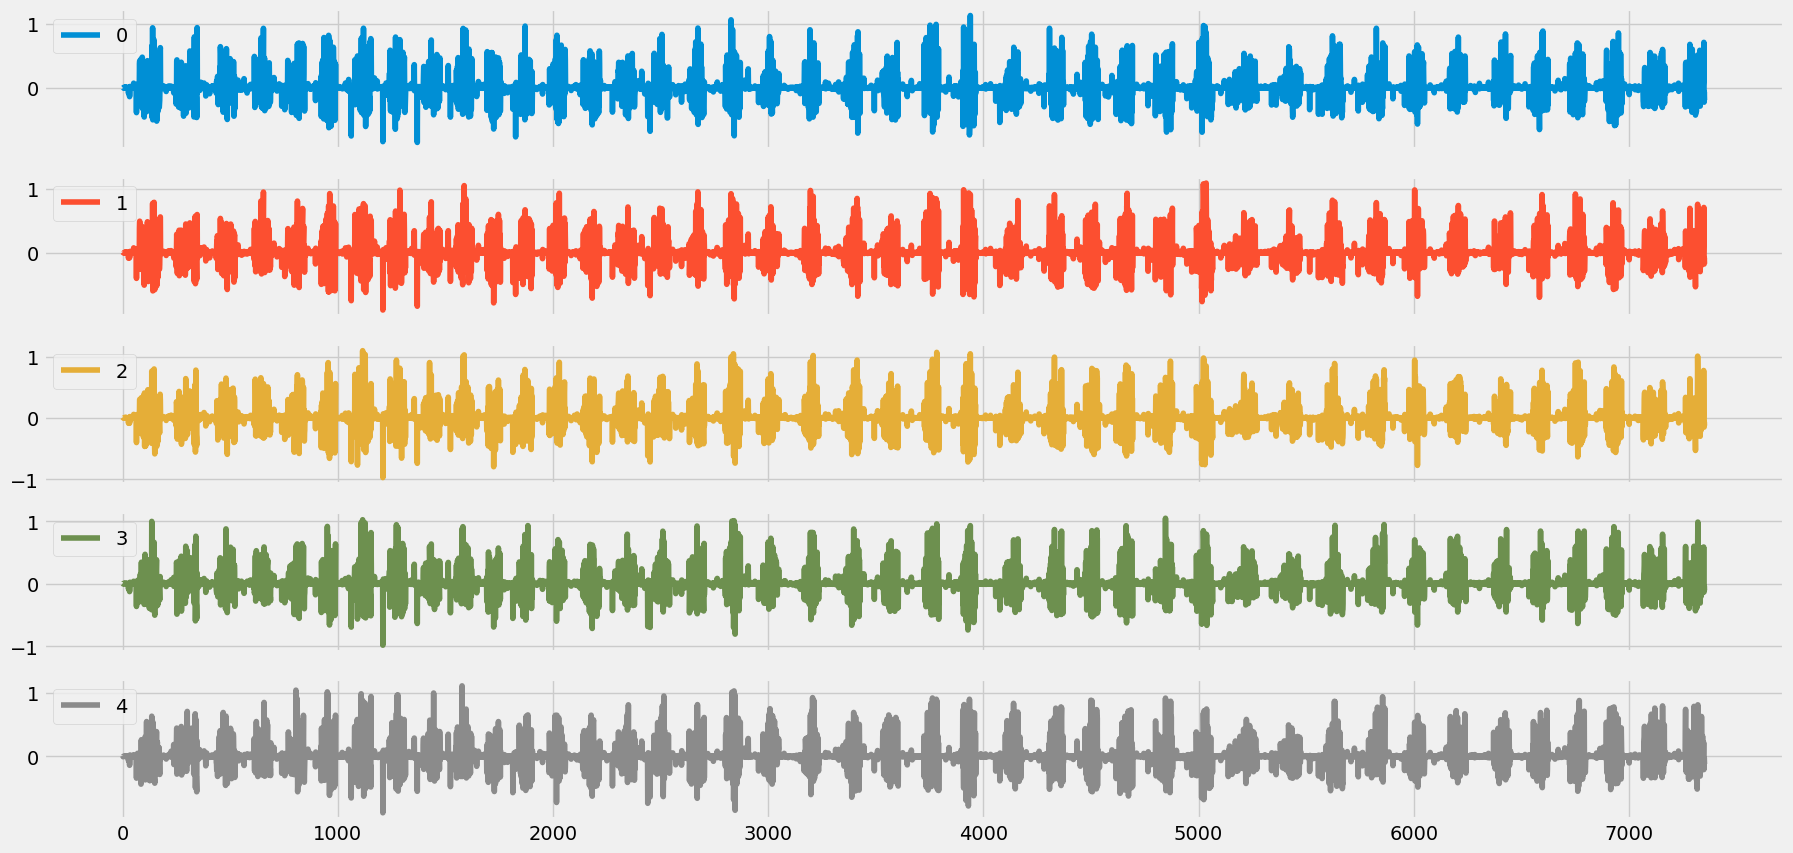

In [ ]:
# 5 столбцов на графике с помощью функции pandas plot
columns_to_plot = data.columns[:5]
data[columns_to_plot].plot(subplots=True, sharex=True, figsize=(20,10))
plt.show()

In [ ]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


# <font color='#11a642' size='6'> Обучение классификатора Случайного леса

## <font color='#11a642' size='5'>Подготовка данных
Разделение данных на тестовую и тренировочную. Тестовая выборка - 20%

In [ ]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=TEST_SIZE)

# Преобразование названий столбцов в строки
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [ ]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
6601,-0.157281,-0.218801,-0.309767,-0.391658,-0.353642,-0.480074,-0.659570,-0.679277,-0.576934,-0.338742,...,-0.052448,-0.159932,-0.279229,-0.161446,-0.173581,-0.225418,-0.256542,-0.437783,-0.583172,-0.575825
3491,-0.003572,-0.002914,-0.000921,0.000316,0.000606,0.001530,0.001746,0.001129,0.000127,0.000334,...,-0.000083,-0.000925,0.001023,0.003478,0.002440,0.000253,-0.000717,-0.001119,-0.001048,-0.000892
3339,0.006367,0.006840,0.005226,0.002883,0.001225,-0.000455,-0.000670,0.000375,-0.000527,-0.002346,...,0.005072,0.001182,-0.003488,-0.001630,-0.000210,-0.001602,0.000923,0.001425,0.000143,0.005409
4416,-0.000173,-0.000157,-0.001532,-0.002075,-0.001805,-0.000826,0.002029,0.001452,-0.000368,0.000689,...,-0.000936,-0.002459,-0.002552,-0.001759,-0.005064,-0.006853,-0.005085,-0.004604,-0.006354,-0.008091
2957,0.009244,0.006335,0.004864,0.002308,0.001897,0.004749,0.007407,0.005862,0.004264,0.005227,...,-0.000958,0.000408,0.003776,0.005499,0.005698,0.004729,0.004558,0.003648,0.003384,0.004289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,-0.077148,0.012861,0.183566,0.285774,0.209722,0.166757,0.194545,0.211009,0.244995,0.185335,...,-0.117436,-0.031359,-0.025226,0.002335,0.033704,-0.056909,-0.028837,-0.060486,-0.082971,-0.042872
4756,0.001610,-0.000780,0.001015,0.001853,-0.001770,-0.003170,-0.000755,0.002590,0.003360,0.001875,...,-0.000159,0.001661,0.002321,0.002820,0.000913,-0.001023,-0.003113,-0.006286,-0.006722,-0.000991
3527,-0.013660,-0.010267,-0.005495,-0.004962,-0.004381,-0.002552,-0.005988,-0.009673,-0.008703,-0.007977,...,0.000839,0.003129,0.004730,0.003648,0.000217,-0.001284,-0.000309,0.002059,0.005184,0.001926
5174,-0.316142,-0.256983,-0.208355,-0.204767,-0.187803,-0.212419,-0.213121,-0.177100,-0.112617,-0.011656,...,-0.000750,-0.048194,-0.118437,-0.146291,-0.183388,-0.218118,-0.213731,-0.206789,-0.187599,-0.193232


## <font color='#11a642' size='5'>Обучение классификатора
Обучение классификатора Случайного леса (DecisionTreeClassifier) на тренировочной выборке

In [ ]:
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## <font color='#11a642' size='5'>Оценка качества классификатора
Оценка классификатора по критериям Accuracy, Precision, Recall и F1 (classification_report)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.63      0.68      0.65       229
           2       0.52      0.52      0.52       221
           3       0.73      0.62      0.67       202
           4       0.31      0.31      0.31       252
           5       0.42      0.40      0.41       292
           6       0.46      0.51      0.48       275

    accuracy                           0.49      1471
   macro avg       0.51      0.50      0.51      1471
weighted avg       0.50      0.49      0.49      1471



Вывод:

Accuracy модели составляет 0.53, что означает, что модель правильно классифицирует примерно 53% случаев.

Класс 3 показывает наилучшие результаты с точностью 0.69, полнотой 0.71 и F1-мерой 0.70. Это означает, что модель хорошо справляется с идентификацией этого класса.
Класс 4 демонстрирует наихудшие результаты с точностью 0.37, полнотой 0.38 и F1-мерой 0.37. Модель испытывает трудности в классификации этого класса.

 Текущие результаты показывают среднюю производительность модели и необходимость в доработке модели и признаков для повышения точности

## <font color='#11a642' size='5'>Отбор значимых признаков
Выбор признаков из классификатора

In [ ]:
# Получение важности признаков
importances = classifier.feature_importances_
importances

array([0.00482081, 0.00580143, 0.00792116, 0.00343273, 0.00489069,
       0.00470451, 0.00532739, 0.00721951, 0.00499521, 0.0031768 ,
       0.00415871, 0.00398636, 0.00774569, 0.00178936, 0.00727573,
       0.00393159, 0.00600025, 0.00361534, 0.00473135, 0.00177912,
       0.00399158, 0.00279604, 0.00505355, 0.00370486, 0.0048887 ,
       0.00310894, 0.00377041, 0.00425096, 0.00309654, 0.00571293,
       0.00348012, 0.00511773, 0.0080516 , 0.00279302, 0.00417959,
       0.00325605, 0.00375868, 0.00295783, 0.0021795 , 0.00374591,
       0.00452238, 0.00875646, 0.00264378, 0.00525859, 0.00738451,
       0.00505142, 0.00468622, 0.00493523, 0.00486931, 0.00454988,
       0.00537507, 0.00151897, 0.01056674, 0.00418673, 0.00258243,
       0.00326059, 0.0035046 , 0.00249369, 0.00789664, 0.00905845,
       0.01248124, 0.00160837, 0.00814062, 0.00384404, 0.00344866,
       0.0098709 , 0.00842208, 0.00733384, 0.00548827, 0.00426751,
       0.00391042, 0.00396254, 0.00530897, 0.00344393, 0.00611

In [ ]:
# Сортировка индексов
sorted_indices = importances.argsort()[::-1]
sorted_indices

array([119, 118, 111, 110, 107, 102, 126,  82, 125, 101,  81,  60,  94,
        99, 124, 104,  78,  52, 115,  76,  65,  87,  77, 123,  95,  59,
        41, 127,  66,  92, 105, 117,  62,  32,  79,  97,   2,  58, 116,
        12,  80,  75,  44,  67,  14, 122,   7,  84,  88, 114,  98, 108,
       109,  74,  16, 106,  89,   1,  29,  68,  91,  50,   6,  72,  43,
       112,  93,  31,  22,  45, 100,   8,  47,   4,  24,  48,  86,   0,
        85,  18,   5,  46,  49,  40,  90,  69,  27,  53,  34,  10,  96,
        20,  11,  71, 113,  15,  70,  63, 120,  26,  36,  39,  23,  17,
        56,  30,  64,  73,   3, 103,  55,  35,   9,  25,  28,  37,  21,
        33,  42, 121,  54,  57,  83,  38,  13,  19,  61,  51])

In [ ]:
# Вывод важности признаков
for f in range(X_train.shape[1]):
    print(f"{f + 1}) {X_train.columns[sorted_indices[f]]}: {importances[sorted_indices[f]]}")

1) 119: 0.1688106902199502
2) 118: 0.019097262170406148
3) 111: 0.01811143453032537
4) 110: 0.01794794520653375
5) 107: 0.017538934276267966
6) 102: 0.016425485412799697
7) 126: 0.016285713149565076
8) 82: 0.014766168124136274
9) 125: 0.01441930314520953
10) 101: 0.013972244164137294
11) 81: 0.013222306140172441
12) 60: 0.012481244087619692
13) 94: 0.012203809984650071
14) 99: 0.01186849203720251
15) 124: 0.011353912144719853
16) 104: 0.010967873066990114
17) 78: 0.010780797384942307
18) 52: 0.010566741794864823
19) 115: 0.010388268269851997
20) 76: 0.01032487341616948
21) 65: 0.009870904463302549
22) 87: 0.009752813624289996
23) 77: 0.009418495142186472
24) 123: 0.00917463245796673
25) 95: 0.009092782945494331
26) 59: 0.009058454624291038
27) 41: 0.008756458787325396
28) 127: 0.008536633357930435
29) 66: 0.008422084436415185
30) 92: 0.008335048110403257
31) 105: 0.008235799436643258
32) 117: 0.008225614858869554
33) 62: 0.008140615689794746
34) 32: 0.008051601353691724
35) 79: 0.00803

In [ ]:
feat_labels = X_train.columns
results = pd.DataFrame(columns=["Column", "Importance"])

# Определение минимальной длины между размером X и длиной sorted_indices
n_features = min(X_train.shape[1], len(sorted_indices), len(importances))

for f in range(n_features):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importances[sorted_indices[f]]))
    results.loc[len(results)] = {
        "Column": feat_labels[sorted_indices[f]],
        "Importance": importances[sorted_indices[f]]
    }

 1) 119                            0.168811
 2) 118                            0.019097
 3) 111                            0.018111
 4) 110                            0.017948
 5) 107                            0.017539
 6) 102                            0.016425
 7) 126                            0.016286
 8) 82                             0.014766
 9) 125                            0.014419
10) 101                            0.013972
11) 81                             0.013222
12) 60                             0.012481
13) 94                             0.012204
14) 99                             0.011868
15) 124                            0.011354
16) 104                            0.010968
17) 78                             0.010781
18) 52                             0.010567
19) 115                            0.010388
20) 76                             0.010325
21) 65                             0.009871
22) 87                             0.009753
23) 77                          

Построение графика важности признаков


In [ ]:
plt.rcParams["figure.figsize"] = (20,10) # размер графиков

plt.style.use('fivethirtyeight') # стиль графиков

# Отображение результатов в виде бара с использованием Plotly Express
fig = px.bar(results[:15],
             x="Column",
             y="Importance",
             title='Важность признаков',
             labels={'x': 'Признаки', 'y': 'Важность признаков'},
             color_discrete_sequence=['#636EFA'])

# Настройка отображения графика
fig.update_layout(
    barmode='group',
    xaxis_title=None,
    yaxis_title=None,
    legend_title=None,
    hovermode='x unified',
    margin=dict(b=100),
    height=600
)

# Отображение графика
fig.show()

Вывод:

Некоторые признаки оказывают гораздо большее влияние на модель, чем другие. Например, признак с индексом 119 имеет очень высокий коэффициент важности(16.88%) и выделяется среди остальных. Этот признак очень важен для модели.

# <font color='#11a642' size='6'> Работа с библиотекой tsfresh

Возврат к загруженным данным до разделения на тестовую и тренировочную выборки.

## <font color='#11a642' size='5'>Генерация признаков extract_features

Применение к датасету функции из библиотеки tsfresh extract_features

In [ ]:
# Добавление столбцов с идентификаторами и временем
data['id'] = range(len(data))  # уникальный идентификатор для каждой строки
data['time'] = range(len(data))  # временной ряд

# Переупорядочим столбцы, чтобы 'id' и 'time' были первыми
data = data[['id', 'time'] + list(data.columns[:-2])]
data

,id,time,0,1,2,3,4,5,6,7,...,118,119,120,121,122,123,124,125,126,127
0,0,0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,1,1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,2,2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,3,3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,4,4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,7347,7347,0.388873,0.618763,0.774067,0.586568,0.217007,-0.027330,-0.171294,-0.218988,...,-0.227949,-0.247119,-0.227710,-0.210942,-0.179295,-0.142085,-0.131831,-0.154000,-0.176886,-0.211068
7348,7348,7348,0.711864,0.709237,0.321368,-0.028921,-0.208107,-0.192802,-0.066754,-0.042285,...,-0.311864,-0.316281,-0.274100,-0.326159,-0.379539,-0.382544,-0.371156,-0.295357,-0.203831,-0.124548
7349,7349,7349,-0.226717,-0.177817,-0.150869,-0.132237,-0.068338,0.007874,0.096481,0.205834,...,-0.177051,-0.248426,-0.313892,-0.367070,-0.395135,-0.347338,-0.319902,-0.294935,-0.243403,-0.215215
7350,7350,7350,-0.064806,-0.079933,-0.068350,-0.038477,-0.028679,0.018335,0.077571,0.253580,...,-0.240819,-0.330930,-0.396854,-0.413906,-0.379085,-0.356609,-0.317618,-0.315016,-0.330737,-0.272348


In [ ]:
data = data.fillna(method='ffill')

In [ ]:
all_features = extract_features(data, column_id="id", column_sort="time",
                                      n_jobs=4, disable_progressbar=False,
                                      default_fc_parameters=MinimalFCParameters(),
                                      impute_function=None)

Feature Extraction: 100%|██████████| 20/20 [06:44<00:00, 20.23s/it]


In [ ]:
all_features

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum,...,127__sum_values,127__median,127__mean,127__length,127__standard_deviation,127__variance,127__root_mean_square,127__maximum,127__absolute_maximum,127__minimum
0,0.000181,0.000181,0.000181,1.0,0.0,0.0,0.000181,0.000181,0.000181,0.000181,...,0.001576,0.001576,0.001576,1.0,0.0,0.0,0.001576,0.001576,0.001576,0.001576
1,0.001094,0.001094,0.001094,1.0,0.0,0.0,0.001094,0.001094,0.001094,0.001094,...,-0.001599,-0.001599,-0.001599,1.0,0.0,0.0,0.001599,-0.001599,0.001599,-0.001599
2,0.003531,0.003531,0.003531,1.0,0.0,0.0,0.003531,0.003531,0.003531,0.003531,...,0.002178,0.002178,0.002178,1.0,0.0,0.0,0.002178,0.002178,0.002178,0.002178
3,-0.001772,-0.001772,-0.001772,1.0,0.0,0.0,0.001772,-0.001772,0.001772,-0.001772,...,-0.000028,-0.000028,-0.000028,1.0,0.0,0.0,0.000028,-0.000028,0.000028,-0.000028
4,0.000087,0.000087,0.000087,1.0,0.0,0.0,0.000087,0.000087,0.000087,0.000087,...,-0.003328,-0.003328,-0.003328,1.0,0.0,0.0,0.003328,-0.003328,0.003328,-0.003328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.388873,0.388873,0.388873,1.0,0.0,0.0,0.388873,0.388873,0.388873,0.388873,...,-0.211068,-0.211068,-0.211068,1.0,0.0,0.0,0.211068,-0.211068,0.211068,-0.211068
7348,0.711864,0.711864,0.711864,1.0,0.0,0.0,0.711864,0.711864,0.711864,0.711864,...,-0.124548,-0.124548,-0.124548,1.0,0.0,0.0,0.124548,-0.124548,0.124548,-0.124548
7349,-0.226717,-0.226717,-0.226717,1.0,0.0,0.0,0.226717,-0.226717,0.226717,-0.226717,...,-0.215215,-0.215215,-0.215215,1.0,0.0,0.0,0.215215,-0.215215,0.215215,-0.215215
7350,-0.064806,-0.064806,-0.064806,1.0,0.0,0.0,0.064806,-0.064806,0.064806,-0.064806,...,-0.272348,-0.272348,-0.272348,1.0,0.0,0.0,0.272348,-0.272348,0.272348,-0.272348


In [ ]:
all_features.columns

Index(['0__sum_values', '0__median', '0__mean', '0__length',
       '0__standard_deviation', '0__variance', '0__root_mean_square',
       '0__maximum', '0__absolute_maximum', '0__minimum',
       ...
       '127__sum_values', '127__median', '127__mean', '127__length',
       '127__standard_deviation', '127__variance', '127__root_mean_square',
       '127__maximum', '127__absolute_maximum', '127__minimum'],
      dtype='object', length=1280)

Применение к датасету функции из библиотеки tsfresh impute

In [ ]:
impute(all_features) # заполнение NaN

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum,...,127__sum_values,127__median,127__mean,127__length,127__standard_deviation,127__variance,127__root_mean_square,127__maximum,127__absolute_maximum,127__minimum
0,0.000181,0.000181,0.000181,1.0,0.0,0.0,0.000181,0.000181,0.000181,0.000181,...,0.001576,0.001576,0.001576,1.0,0.0,0.0,0.001576,0.001576,0.001576,0.001576
1,0.001094,0.001094,0.001094,1.0,0.0,0.0,0.001094,0.001094,0.001094,0.001094,...,-0.001599,-0.001599,-0.001599,1.0,0.0,0.0,0.001599,-0.001599,0.001599,-0.001599
2,0.003531,0.003531,0.003531,1.0,0.0,0.0,0.003531,0.003531,0.003531,0.003531,...,0.002178,0.002178,0.002178,1.0,0.0,0.0,0.002178,0.002178,0.002178,0.002178
3,-0.001772,-0.001772,-0.001772,1.0,0.0,0.0,0.001772,-0.001772,0.001772,-0.001772,...,-0.000028,-0.000028,-0.000028,1.0,0.0,0.0,0.000028,-0.000028,0.000028,-0.000028
4,0.000087,0.000087,0.000087,1.0,0.0,0.0,0.000087,0.000087,0.000087,0.000087,...,-0.003328,-0.003328,-0.003328,1.0,0.0,0.0,0.003328,-0.003328,0.003328,-0.003328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.388873,0.388873,0.388873,1.0,0.0,0.0,0.388873,0.388873,0.388873,0.388873,...,-0.211068,-0.211068,-0.211068,1.0,0.0,0.0,0.211068,-0.211068,0.211068,-0.211068
7348,0.711864,0.711864,0.711864,1.0,0.0,0.0,0.711864,0.711864,0.711864,0.711864,...,-0.124548,-0.124548,-0.124548,1.0,0.0,0.0,0.124548,-0.124548,0.124548,-0.124548
7349,-0.226717,-0.226717,-0.226717,1.0,0.0,0.0,0.226717,-0.226717,0.226717,-0.226717,...,-0.215215,-0.215215,-0.215215,1.0,0.0,0.0,0.215215,-0.215215,0.215215,-0.215215
7350,-0.064806,-0.064806,-0.064806,1.0,0.0,0.0,0.064806,-0.064806,0.064806,-0.064806,...,-0.272348,-0.272348,-0.272348,1.0,0.0,0.0,0.272348,-0.272348,0.272348,-0.272348


Применение к датасету функции из библиотеки tsfresh select_features

In [ ]:
features_filtered = select_features(all_features, y) # Выбор наиболее подходящих признаков

In [ ]:
features_filtered

,87__root_mean_square,87__absolute_maximum,96__absolute_maximum,96__root_mean_square,108__absolute_maximum,108__root_mean_square,115__root_mean_square,115__absolute_maximum,114__root_mean_square,114__absolute_maximum,...,88__maximum,88__minimum,88__sum_values,88__median,88__mean,44__maximum,44__median,44__sum_values,44__minimum,44__mean
0,0.000751,0.000751,0.001904,0.001904,0.000065,0.000065,0.000636,0.000636,0.001765,0.001765,...,0.000389,0.000389,0.000389,0.000389,0.000389,-0.000680,-0.000680,-0.000680,-0.000680,-0.000680
1,0.000478,0.000478,0.000569,0.000569,0.000679,0.000679,0.002166,0.002166,0.003386,0.003386,...,-0.001506,-0.001506,-0.001506,-0.001506,-0.001506,0.000065,0.000065,0.000065,0.000065,0.000065
2,0.000677,0.000677,0.002201,0.002201,0.001945,0.001945,0.000552,0.000552,0.000533,0.000533,...,0.002138,0.002138,0.002138,0.002138,0.002138,-0.000679,-0.000679,-0.000679,-0.000679,-0.000679
3,0.000221,0.000221,0.001546,0.001546,0.000898,0.000898,0.001230,0.001230,0.001986,0.001986,...,0.001470,0.001470,0.001470,0.001470,0.001470,-0.001945,-0.001945,-0.001945,-0.001945,-0.001945
4,0.003230,0.003230,0.003734,0.003734,0.000153,0.000153,0.000765,0.000765,0.001411,0.001411,...,-0.001015,-0.001015,-0.001015,-0.001015,-0.001015,-0.000898,-0.000898,-0.000898,-0.000898,-0.000898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.133162,0.133162,0.017321,0.017321,0.378512,0.378512,0.125762,0.125762,0.085427,0.085427,...,-0.036709,-0.036709,-0.036709,-0.036709,-0.036709,-0.202900,-0.202900,-0.202900,-0.202900,-0.202900
7348,0.222148,0.222148,0.029798,0.029798,0.266131,0.266131,0.050178,0.050178,0.073925,0.073925,...,-0.245844,-0.245844,-0.245844,-0.245844,-0.245844,0.378512,0.378512,0.378512,0.378512,0.378512
7349,0.166334,0.166334,0.009242,0.009242,0.534900,0.534900,0.083596,0.083596,0.091123,0.091123,...,-0.205544,-0.205544,-0.205544,-0.205544,-0.205544,0.266131,0.266131,0.266131,0.266131,0.266131
7350,0.141416,0.141416,0.006175,0.006175,0.458271,0.458271,0.048764,0.048764,0.007803,0.007803,...,-0.190921,-0.190921,-0.190921,-0.190921,-0.190921,0.534900,0.534900,0.534900,0.534900,0.534900


Вывод о новых столбцах:

При генерации признаков с помощью tsfresh был использован минимальный набор параметров (MinimalFCParameters). Это позволило выделить такие признаки, как сумма, медиана, стандартное отклонение, максимумы и минимумы для каждого из столбцов исходных данных. Количество новых признаков составило 1280.

После генерации и заполнения пропущенных значений с помощью impute, был выполнен отбор с помощью select_features, что привело к сокращению числа признаков до 896. Это исключает менее значимые признаки, что помогает улучшить производительность моделей машинного обучения за счет сокращения размерности данных.

## <font color='#11a642' size='5'>Генерация признаков extract_relevant_features

Применение к датасету функции из библиотеки tsfresh extract_relevant_features

In [ ]:
relevant_features = extract_relevant_features(
    data,
    y,
    column_id='id',
    column_sort='time',
    default_fc_parameters=MinimalFCParameters()
)

Feature Extraction: 100%|██████████| 941056/941056 [04:43<00:00, 3325.18it/s]


In [ ]:
relevant_features.head()

,87__root_mean_square,87__absolute_maximum,96__absolute_maximum,96__root_mean_square,108__absolute_maximum,108__root_mean_square,115__root_mean_square,115__absolute_maximum,114__root_mean_square,114__absolute_maximum,...,88__maximum,88__minimum,88__sum_values,88__median,88__mean,44__maximum,44__median,44__sum_values,44__minimum,44__mean
0,0.000751,0.000751,0.001904,0.001904,0.000065,0.000065,0.000636,0.000636,0.001765,0.001765,...,0.000389,0.000389,0.000389,0.000389,0.000389,-0.000680,-0.000680,-0.000680,-0.000680,-0.000680
1,0.000478,0.000478,0.000569,0.000569,0.000679,0.000679,0.002166,0.002166,0.003386,0.003386,...,-0.001506,-0.001506,-0.001506,-0.001506,-0.001506,0.000065,0.000065,0.000065,0.000065,0.000065
2,0.000677,0.000677,0.002201,0.002201,0.001945,0.001945,0.000552,0.000552,0.000533,0.000533,...,0.002138,0.002138,0.002138,0.002138,0.002138,-0.000679,-0.000679,-0.000679,-0.000679,-0.000679
3,0.000221,0.000221,0.001546,0.001546,0.000898,0.000898,0.001230,0.001230,0.001986,0.001986,...,0.001470,0.001470,0.001470,0.001470,0.001470,-0.001945,-0.001945,-0.001945,-0.001945,-0.001945
4,0.003230,0.003230,0.003734,0.003734,0.000153,0.000153,0.000765,0.000765,0.001411,0.001411,...,-0.001015,-0.001015,-0.001015,-0.001015,-0.001015,-0.000898,-0.000898,-0.000898,-0.000898,-0.000898


In [ ]:
# Сравнение количества признаков
print(f"Количество признаков (extract_features): {all_features.shape[1]}")
print(f"Количество релевантных признаков (extract_relevant_features): {relevant_features.shape[1]}")

Количество признаков (extract_features): 1280
Количество релевантных признаков (extract_relevant_features): 896


# <font color='#11a642' size='6'> Обучение классификатора Случайного леса на новых признаках

## <font color='#11a642' size='5'>Подготовка данных
Разделение данных на тестовую и тренировочную. Тестовая выборка - 20%

In [ ]:
# Обучение модели на полном наборе признаков
TEST_SIZE = 0.2

X_train_full, X_test_full, y_train, y_test = train_test_split(all_features, y, test_size=0.2, random_state=42)

In [ ]:
# Обучение модели на релевантных признаках
X_train_relevant, X_test_relevant, y_train, y_test = train_test_split(relevant_features, y, test_size=0.2, random_state=42)

## <font color='#11a642' size='5'>Обучение классификатора
Обучение классификатора Случайного леса (DecisionTreeClassifier) на тренировочной выборке с отфильтрованными данными

In [ ]:
# Обучение классификатора на полном наборе признаков
classifier_full = DecisionTreeClassifier(random_state=42)
classifier_full.fit(X_train_full, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Обучение классификатора на релевантных признаках
classifier_relevant = DecisionTreeClassifier(random_state=42)
classifier_relevant.fit(X_train_relevant, y_train)

DecisionTreeClassifier(random_state=42)

## <font color='#11a642' size='5'>Оценка качества классификатора
Оценка классификатора по критериям Accuracy, Precision, Recall и F1 (classification_report)

In [ ]:
# Оценка модели на тестовых данных
y_pred_full = classifier_full.predict(X_test_full)

In [ ]:
y_pred_relevant = classifier_relevant.predict(X_test_relevant)

In [ ]:
print("Результаты для полного набора признаков (extract_features):")
print(classification_report(y_test, y_pred_full))

Результаты для полного набора признаков (extract_features):
              precision    recall  f1-score   support

           1       0.62      0.64      0.63       247
           2       0.49      0.52      0.51       200
           3       0.74      0.65      0.69       206
           4       0.38      0.33      0.35       262
           5       0.42      0.46      0.44       276
           6       0.49      0.51      0.50       280

    accuracy                           0.51      1471
   macro avg       0.52      0.52      0.52      1471
weighted avg       0.51      0.51      0.51      1471



In [ ]:
print("Результаты для релевантных признаков (extract_relevant_features):")
print(classification_report(y_test, y_pred_relevant))

Результаты для релевантных признаков (extract_relevant_features):
              precision    recall  f1-score   support

           1       0.61      0.64      0.62       247
           2       0.50      0.52      0.51       200
           3       0.71      0.64      0.68       206
           4       0.35      0.30      0.32       262
           5       0.42      0.46      0.44       276
           6       0.48      0.50      0.49       280

    accuracy                           0.50      1471
   macro avg       0.51      0.51      0.51      1471
weighted avg       0.50      0.50      0.50      1471



Вывод:

Обе модели дают схожие результаты по метрикам.

При использовании extract_relevant_features было получено меньше признаков. Это помогло снизить вычислительную сложность модели, что важно для производительности на больших данных.

Общий вывод:

Отбор признаков с помощью классификатора и tsfresh позволяет существенно уменьшить размерность данных без потери качества классификации. Это делает модель быстрее, проще в интерпретации и снижает риск переобучения.